# Definitions

In [ ]:
import pandas as pd
from nltk import word_tokenize
import pronouncing
with open("../data/custom_pronouncing.dict", mode='rb') as f:
    pronouncing.init_cmu(f)
pronouncing.phones_for_word("resistances")
import sys
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageOps
import PillowPatch
from nltk.corpus import wordnet as wn
import re
import random
import math

## TODO

- center page numbering
- Mailchimp API
- use text image from the actual scan
- spellcheck ([pyEnchant](http://pythonhosted.org/pyenchant/tutorial.html]))

In [ ]:
with pd.HDFStore('dictionary.h5') as store:
    definitions = store['/definitions']

In [ ]:
def join_text(x):
    text = " ".join(x['text'][:2].tolist())
    return pd.DataFrame(text, columns='text')

# One definition per line, regardless of place in book
fulldefs = definitions.sort_values(['word_group', 'part'])\
                       .groupby('word_group')[['text', 'word']]\
                       .agg({'text': lambda x: " ".join(x), 'word': 'first'})\
                       .query("word != ''")
fulldefs.sample(2)

,text,word
word_group,,
15380,"EXTRICABLE (eks’tri-ka-bl), a. That may or \n ...",EXTRICABLE
11528,"DERIVATIVE (de-riv’a—tiv), I. a. 1. Derived \n...",DERIVATIVE


In [ ]:
def line_tokenize(definition):
    from nltk import sent_tokenize
    import re
    nosemi = definition.replace("; ", ". ")
    lines = sent_tokenize(nosemi)
    nonum = [line for line in lines if re.search('^[A-Za-z]', line)]
    return nonum

In [ ]:
# Its a small enough dataset to write multiple (easier to read) cleaning functions
# rather than one big, dense regex

# strip cleanly ocr'd brackets
# strip badly ocr'd brackets, with their nearest non whitespace chars
fulldefs['text_clean'] = fulldefs['text'].str.replace(' \n ', ' ')\
            .str.replace('\(.{1,15}\)','')\
            .str.replace('\[.{1,15}\]','')\
            .str.replace('( \S+\)|\(\S+ )', ' ')\
            .str.replace(' [\.,] ', ' ')\
            .str.replace(' (n|c|a|adv)\. ', ' ')\
            .str.replace('^[A-Z\-]+ ?', '')\
            .str.replace('\- ', '')\
            .str.replace('—', ' ')\
            .str.replace('\‘s', "'s")\
            .str.replace('\‘\S? ', '')\
            .str.replace('ﬂ', 'ff')\
            .str.replace('ﬁ', 'fi')
            
fulldefs['text_clean'].tail(10)

word_group
39355     Causing fer-q mentation; as, zymogenic bacteria.
39356      ZYMOLOGICAL,a. Of or pertaining to 25'. mology.
39357                                         in zymology.
39358    11. Science of fer mentation. [ZYll'E and -0LO...
39359    Instrumen for detecting the condition and proc...
39360    Bacterial fermen that separates fatty acids fr...
39361    Instrument to testing the fermenting power of ...
39362    Pathol. Process of fer mentation by which a ma...
39363    Pertaining to, or pro duced by, fermentation. ...
39364    Departmentof tech nological chemistry which tr...
Name: text_clean, dtype: object

In [ ]:
expanded_txts = fulldefs['text_clean'].apply(line_tokenize).apply(lambda x: pd.Series(x)).unstack().reset_index(level=0, drop=True).reset_index().dropna().sort_values('word_group')
defsents = fulldefs.join(expanded_txts.set_index('word_group')).rename(columns={0: 'sent'})[['word', 'sent']]
defsents['sent'] = defsents['sent'].astype(str)
defsents.sample(6)

,word,sent
word_group,,
33888,STAG-ER,n 1.
32565,SIPPED,I. vt. 1.
11514,DERANGEMENT,dclirium.
29867,RELATBE,narrator.
35588,TEETEB,teetering.
29011,RACKET,imam.


In [ ]:
def get_words(sent):
    words = word_tokenize(sent)
    return [word.lower() for word in words if re.search("^[A-Za-z\-]+", word)]

def syllables(word, fill_missing=2):
    pronunciation_list = pronouncing.phones_for_word(word.lower())
    if pronunciation_list:
        return pronouncing.syllable_count(pronunciation_list[0])
    else:
        return fill_missing
    
def stresses(word, fill_missing=""):
    phones_list = pronouncing.phones_for_word(word.lower())
    if len(phones_list) == 0:
        return fill_missing
    return pronouncing.stresses(phones_list[0])

def rhythm(sent_stresses):
    if len(sent_stresses) == 1:
        return 1
    # Count how often the syllables alternate between stressed and unstressed
    flips = sum([x!=y for x,y in zip(list(sent_stresses[:-1]), list(sent_stresses[1:]))])
    return flips / (len(sent_stresses)-1)

In [ ]:
badchars = defsents['sent'].str.findall('[A-Z\d\[\]\(\)]').apply(len)
lens = defsents['sent'].apply(len)

reject1 = (badchars > 3) & (lens < 15)
reject2 = (badchars > 5)
reject3 = (lens < 15)
reject4 = defsents['sent'].str.endswith(']')

defsents_sample = defsents[~reject1 & ~reject2 & ~reject3 & ~reject4].copy()

defsents_sample['def_words'] = defsents_sample['sent'].apply(get_words)
defsents_sample['last_word'] = defsents_sample['def_words'].apply(lambda x: x[-1])
defsents_sample['word_stresses'] = defsents_sample['word'].apply(stresses)
defsents_sample['word_syllables'] = defsents_sample['word'].apply(syllables)
defsents_sample['word_len'] = defsents_sample['word'].apply(len)

defsents_sample['syllable_count'] = defsents_sample['def_words'].apply(lambda words: sum([syllables(word) for word in words]))
defsents_sample['sent_stresses'] = defsents_sample['def_words'].apply(lambda x: "".join([stresses(word) for word in x]).replace('2', '1'))
defsents_sample['rhythm'] = defsents_sample['sent_stresses'].apply(rhythm)

defsents_sample.sample(2)

,word,sent,def_words,last_word,word_stresses,word_syllables,word_len,syllable_count,sent_stresses,rhythm
word_group,,,,,,,,,,
34493,STRENGTH,amount of alcohol contained.,"[amount, of, alcohol, contained]",contained,1,1,8,8,01110101,0.714286
17597,GRALLATORIAL,"as the crane, stork.","[as, the, crane, stork]",stork,,0,12,4,1011,0.666667


In [ ]:
defsents_sample.query('rhythm == 1').sample(10)

,word,sent,def_words,last_word,word_stresses,word_syllables,word_len,syllable_count,sent_stresses,rhythm
word_group,,,,,,,,,,
36793,TRAMP,"Wander, as a tramp.","[wander, as, a, tramp]",tramp,1,1,5,5,10101,1.0
25202,ORTHOEPICALLY,With correct pronunciation.,"[with, correct, pronunciation]",pronunciation,,2,13,8,10101010,1.0
650,AFTER,Behind in place.,"[behind, in, place]",place,10,2,5,4,0101,1.0
25035,ON,About the body.,"[about, the, body]",body,1,1,2,5,01010,1.0
15428,FABRIC,Manufactured cloth.,"[manufactured, cloth]",cloth,10,2,6,5,10101,1.0
17298,GLANCE,Darting oi the eye.,"[darting, oi, the, eye]",eye,1,1,6,5,10101,1.0
25552,JERSEY,Largest of the English Channel Islands.,"[largest, of, the, english, channel, islands]",islands,10,2,6,10,1010101010,1.0
6441,CERUMEN,Wax secreted by the ear.,"[wax, secreted, by, the, ear]",ear,,0,7,7,1010101,1.0
38150,VEEEED,Change direction.,"[change, direction]",direction,,2,6,4,1010,1.0


## Extending the CMU pronouncing dictionary

I expanded the CMU dictionary with some inferred pronounciations. This was done by finding all the unique words and seeing which ones are not in the CMU dictionary.

```python
all_words = []
for row in defsents_sample['def_words'].values:
    all_words.extend(row)
to_add = [word for word in set(all_words) if len(pronouncing.phones_for_word(word)) == 0]
with open('../data/candidates-for-new-dict.txt', mode='w') as f:
    f.write("\n".join(to_add))
```

These are also good spelling correction candidates (future work).

`candidates-for-new-dict.txt` was then be uploaded to the [lextool](http://www.speech.cs.cmu.edu/tools/lextool.html), to generate a custom dict for appending to the CMU pronouncing dictionary.

In [ ]:
def shortest_path(target_synsets, x, fill_missing=12):
    xsynsets = wn.synsets(x)
    distances = []
    for xsynset in xsynsets:
        dists =  [synset.shortest_path_distance(xsynset) for synset in target_synsets]
        dists = [dist for dist in dists if dist]
        if len(dists) > 0:
            distances.append(min(dists))
    if len(distances) > 0:
        return min(distances)
    else:
        return fill_missing

In [ ]:
def get_rhyme(query=None, min_len=3, max_len=13, sent_len=None, min_count=2):
    while True:
        candidates = defsents_sample
        
        # legacy: named length
        if sent_len == "short":
            max_len = 6
        elif sent_len == "long":
            min_len = 10
        if min_len:
            candidates = candidates.query('syllable_count >= %d' % min_len)
        if max_len:
            candidates = candidates.query('syllable_count <= %d' % max_len)
        if query:
            candidates = candidates.query('word == "%s"' % query.upper())
        
        if candidates.empty:
            break
        
        target = candidates.sample(1).iloc[0]
            
        rhymes = pronouncing.rhymes(target['last_word'])
        
        if len(rhymes) == 0:
            continue

        rhyme_matches = defsents_sample[defsents_sample['last_word'].isin(rhymes)].copy()
        rhyme_matches['syllable_diff'] = (rhyme_matches['syllable_count'] - target['syllable_count']).abs()
        # word_syllable_diff requires all words to have a pronounciation, which loses fun words
        #rhyme_matches['word_syllable_diff'] = (rhyme_matches['word_syllables'] - target['word_syllables']).abs()
        rhyme_matches['word_len_diff'] = (rhyme_matches['word_len'] - target['word_len']).abs()
        
        target_synsets = wn.synsets(target['word'])
        if len(target_synsets) > 0:
            rhyme_matches['shortest_path'] = rhyme_matches['word'].apply(lambda x: shortest_path(target_synsets, x))
        else:
            # placeholder
            rhyme_matches['shortest_path'] = 15
            
        # Filter to close syllabic match and no duplicate words
        rhyme_matches = rhyme_matches.query('syllable_diff <= 2')\
                                     .groupby('last_word', as_index=False).first()
            
        if rhyme_matches.empty:
            continue
        if rhyme_matches.shape[0] < (1+min_count):
            continue
        rhyme_matches = rhyme_matches.sort_values(['shortest_path', 'rhythm'], ascending=[False, True])
        break
    
    return [tuple(target[['word', 'sent']])] + rhyme_matches[['word', 'sent']].apply(tuple, axis=1).tolist()

r = get_rhyme()
r[:5]

[('NOSTRIL', 'One of the apertures of the nose.'),
 ('DIGITIGRADE', 'Walking on the toes.'),
 ('SETTLE', 'Render quiet, clear, etc.. compose.'),
 ('ROSE', 'the color of the rose.'),
 ('BATTER', 'Beat with succeSSIVe blows.')]

In [ ]:
import logging

class Rhymes():
    
    def __init__(self, rhymes):
        self.rhymes = rhymes
        # A generator is started on initialization, since the verse
        # is expected to only be used once.
        self._verse_gen = self._verse_iter()
        
    def _verse_iter(self): 
        for rhyme in self.rhymes:
            yield rhyme
            
    def verse(self, comma=False, capitalize=False, lower=False):
        defword, verse = next(self._verse_gen)
        if capitalize and lower:
            logging.warn("You have competing capitalization options!")

        if comma:
            # Replace trailing period with comma
            verse = re.sub("\.$", ", ", verse)
            
        if capitalize:
            verse = verse.capitalize()
            
        if lower:
            verse = verse[0].lower() + verse[1:]

        return (defword, verse)
           
def print_pattern(pattern):
    title = " ".join([title for title, defn in pattern]).upper()
    print(title)
    for title, defn in pattern:
        print(defn)
        
def limerick(**kwargs):
    a = Rhymes(get_rhyme(sent_len="short", min_count=3, **kwargs))
    b = Rhymes(get_rhyme(sent_len="long", min_count=2, **kwargs))
    
    poem = [a.verse(), a.verse(), b.verse(), b.verse(), a.verse()]
    return poem

def ballade(**kwargs):
    '''ABABBCBC BCBC'''
    a = Rhymes(get_rhyme(min_count=2, **kwargs))
    b = Rhymes(get_rhyme(min_count=6, **kwargs))
    c = Rhymes(get_rhyme(min_count=4, **kwargs))
    
    poem = [a.verse(), b.verse(), a.verse(), b.verse(), b.verse(), c.verse(), b.verse(), c.verse(),
            ("\n", ""), b.verse(), c.verse(), b.verse(), c.verse()]
    return poem

def cinquian(**kwargs):
    a = Rhymes(get_rhyme(min_count=2, **kwargs))
    b = Rhymes(get_rhyme(min_count=3, **kwargs))
    
    poem = [a.verse(), b.verse(), a.verse(), b.verse(), b.verse(), a.verse()]
    return poem

def alternate(**kwargs):
    a = Rhymes(get_rhyme(min_count=2, **kwargs))
    b = Rhymes(get_rhyme(min_count=2, **kwargs))
    
    poem = [a.verse(comma=True, capitalize=True),
            b.verse(lower=True),
            a.verse(comma=True, capitalize=True),
            b.verse(lower=True)]
    return poem

def abab_cdcd(**kwargs):
    return alternate() + [("\n","")] + alternate()

def couplet(**kwargs):
    a = Rhymes(get_rhyme(min_count=2, **kwargs))
    
    return [a.verse(comma=True, capitalize=True),
            a.verse(lower=True)]

def couplets(**kwargs):
    aa = couplet(**kwargs)
    bb = couplet(**kwargs)
    cc = couplet(**kwargs)
    space = [("\n","")]
    
    return aa + space + bb + space + cc

def sonnet(**kwargs):
    '''"ABAB CDCD EFEF GG"'''
    abab = alternate(**kwargs)
    cdcd = alternate(**kwargs)
    efef = alternate(**kwargs)
    gg = couplet(**kwargs)
    space = [("\n","")]
    return abab + space + cdcd + space + efef + space + gg

In [ ]:
a = "ABCDEF FAEBDC CFDABE ECBFAD DEACFB BDFECA DEF"
b = pd.Series(list(a)).value_counts()
b

F    7
D    7
E    7
B    6
C    6
     6
A    6
dtype: int64

In [ ]:
verses = dict()
for rhyme, count in b.iteritems():
    if rhyme == ' ':
        verses[rhyme] = Rhymes([("\n","")]*count).verse()
    else:
        verses[rhyme] = Rhymes(get_rhyme(min_count=count))
verses

{' ': ('\n', ''),
 'A': <__main__.Rhymes at 0x7f515f003710>,
 'B': <__main__.Rhymes at 0x7f515ecb2198>,
 'C': <__main__.Rhymes at 0x7f517ed03240>,
 'D': <__main__.Rhymes at 0x7f515ed38080>,
 'E': <__main__.Rhymes at 0x7f515f21e320>,
 'F': <__main__.Rhymes at 0x7f516637a630>}

In [ ]:
a = Rhymes(get_rhyme(min_count=2))
b = Rhymes(get_rhyme(min_count=2))

In [ ]:
def sestina_join(rhyme1, rhyme2):
    ''' Get the internal rhymes for the seventh stanza'''
    title = rhyme1[0]+"/"+rhyme2[0]
    verse = rhyme1[1]+" "+rhyme2[1]
    return (title,verse)

def sestina(**kwargs):
    '''ABCDEF FAEBDC CFDABE ECBFAD DEACFB BDFECA DEF'''
    a = Rhymes(get_rhyme(min_count=7, max_len=4, **kwargs))
    b = Rhymes(get_rhyme(min_count=7, max_len=4, **kwargs))
    c = Rhymes(get_rhyme(min_count=7, max_len=4, **kwargs))
    d = Rhymes(get_rhyme(min_count=7, max_len=4, **kwargs))
    e = Rhymes(get_rhyme(min_count=7, max_len=4, **kwargs))
    f = Rhymes(get_rhyme(min_count=7, max_len=4, **kwargs))
    space = ("\n","")
    
    poem = [a.verse(), b.verse(), c.verse(), d.verse(), e.verse(), f.verse(), space,
            f.verse(), a.verse(), e.verse(), b.verse(), d.verse(), c.verse(), space,
            c.verse(), f.verse(), d.verse(), a.verse(), b.verse(), e.verse(), space,
            e.verse(), c.verse(), b.verse(), f.verse(), a.verse(), d.verse(), space,
            d.verse(), e.verse(), a.verse(), c.verse(), f.verse(), b.verse(), space,
            b.verse(), d.verse(), f.verse(), e.verse(), c.verse(), a.verse(), space]
    
    # Faked. Ideally, I'd find shorter verses for the same rhymes. TODO
    last_stanza = [sestina_join(a.verse(comma=True), d.verse()),
                   sestina_join(b.verse(comma=True), e.verse()),
                   sestina_join(c.verse(comma=True), f.verse())]
    return poem + last_stanza

In [ ]:
p = sestina()
print_pattern(p)

NOD WEED EOACH CRUDE CLOSE DEPOT 
 COMMUTE CIEUMB BOBBINET SWEDISH IBIPAIRBIENT ARGIL 
 MIGHT PROFANATION COJIPABABLE CORONADITE EXCESS DASALT 
 FLESH BANDOG READY REPARATION LEGIBLE DESPITE 
 ANCHORESS IGNOMINY AFFBIGHT ID DISABILITY IDIPEDIMENT 
 STROKESMAN DECLARATION AUTOPSY BEARD SLEW BEDCLOTHES 
 FLORID/READY REPLY/ASCENDANT BICKER/DEDUCTION
Quick declination of the head.
Free from weeds.
Thoroughfare: way.
Raw, unprepared.
Enclosed place.
Railway station.

Effect :1 commutation.
Small bit of bread.
Machine-made net or lace.
Language of the Swedes.
State of being impaired.
Potters’ White clay.

Past tense of MAY.
Act of profaning: desecration.
That may be compared.
Black manganate of lead.
That which exceeds.
basis, stepping, base.

Mankind: hu  man race.
Large, fierce dog re.
Ornamentcd with beads.
Indemnification.
That may be read.
Extreme malice or haired.

and, back, and shared.
Public disgrace.
object of dread.
that is to say.
disqualification.
That which impedes.

Whose str

In [ ]:
p = sonnet(max_len=5)
print_pattern(p)

BUDDY DISTRACTEDLY TRACEABLE ATTRACTABLE 
 BLOWHOLE PERCEPTION CHEAPNESS TEXTILE 
 TRADE REJECT COT RIVE 
 THEN ANHYDRITE
Not in good taste, 
like one distracted.
That may be traced, 
that may be attracted.

Air-hole in the ice, 
act of perceiving.
Lowuess of price, 
pertaining to weaving.

Buying and selling, 
refuse to receive.
Small dwelling, 
i. ct. Split or cleave.

At another time, 
anhydrous sulphate of lime.


In [ ]:
p = abab_cdcd()
print_pattern(p)

LOOKED DIASTOLE PINCEED HARE 
 HEW DIVAGATION CHINKED BIWEEKLY
Luuk on, regard, 
diastole, a drawing apart.
Bear or press hard, 
hurk back, go back for a fresh start.

Out with an ax, 
a digresslon or deviation.
Fill up chinks or cracks, 
biweekly publication.


In [ ]:
p = couplets()
print_pattern(p)

CENTRALITY EVERLASTING 
 DEPICT BOOT 
 RACECOURSE TONNAGE
Central position, 
without intermission.

Paint, portray, or make a likeness of, 
t0 boot, over and above.

Course or path over which races are run, 
duty on ships, estimated per ton.


In [ ]:
p = cinquian()
print_pattern(p)

CUCURBIT IDOMENUS VERVAIN NEST CROSSCUT NICARAGUA
State or Resembling a
King of Crete Who engaged in the Trojan war.
Plant of the genus Verbena.
Egg left in the nest to induce the hen to lay more.
Drift irom a shaft to intersect vein of ore.
Capital, Managua.


In [ ]:
p = limerick()
print_pattern(p)

RENOVATE MAD NOD BATHOMETER DEAN
Make new again.
Derangcrl: insane.
Quick declination of the top of anything, as a tree.
Instrument for measuring depths of the sea.
decanus, chiei of ten.


In [ ]:
p = alternate()
print_pattern(p)

AUBICULAR PRESUMPTION CHEER BLOSSOM
Confided to the ear, 
act of presuming.
Be of good cheer, 
state or blooming.


In [ ]:
p = ballade()
print_pattern(p)

DRIVE UNKNOWABLE SHONE APPROPRIATE BASS-DRUM INVOCATION CAUSEWAY SECKEL 
 BLOW CONCESSIONER ANONYM HARE
Carry on: prosecute.
One who or that which is not known.
One whose Young branch;offshoot.
Take to one’s self as one's own.
Drum of largest size with deep low tone.
Addressing in prayer.
Pathway raised and paved with stone.
Small juicy pear.

Sound, as a horn when blown.
Concessionaire.
One whose name is unknown.
S. harm] European Hare.


27 5
26 10
25 15
24 20
23 25
22 30
21 35
20 40
19 45
18 50
17 55
16 60
15 65
14 75
13 90


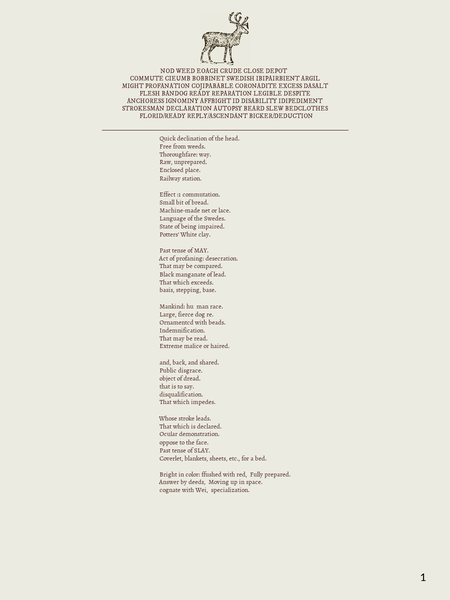

In [ ]:
def get_illustration():
    import glob
    imgpaths = glob.glob("../data/illustration_images/*")
    import random
    while True:
        path = random.choice(imgpaths)
        im = Image.open(path)
        if ((im.size[0]/im.size[1]) > 0.6) and ((im.size[0]/im.size[1]) < 1.2) and (im.size[0]*im.size[1]) > 14000:
            break
    return im

def create_img_mask(img):
    imgb = ImageEnhance.Brightness(img)
    imgc = ImageEnhance.Contrast(imgb.enhance(1.3))
    imgmask = ImageOps.invert(imgc.enhance(3).convert('L'))
    return imgmask

def draw_page(title, poem, style="book", page_num=False, annotate=False):
    
    hsize = 1200
    wsize = 900
    wmargin=100
    hmargin=60
    toppos = 560
    page_color = (235, 235, 225)
    ink_color = (70,30,30)
    #annotate_color = (190,170,170)
    annotate_color = (205,180,180)
    illustration_height = 360
    title_fsize = 33
    poem_fsize = 28
    pnum_fsize = 22
    pnum_pad = 60
    line_spacing = 25
    annotation_pad = 10
    
    if style == "tweet":
        hsize = 1100
        wsize = 900
        wmargin=50
        hmargin=30
        toppos = 520

    im = Image.new('RGB', (wsize, hsize), color=page_color)
    draw = ImageDraw.Draw(im)
    
    annotation = "\n".join([word.replace("\n", "").capitalize() for word in title.split(' ')])
    
    # Size the poem
    j, k = 1, 1
    orig_wmargin=wmargin
    while True:
        font = ImageFont.truetype("../fonts/Sahitya-Regular.ttf", poem_fsize)
        annotefont = ImageFont.truetype("../fonts/Sahitya-Regular.ttf", poem_fsize)
        
        poemw, poemh = draw.textsize(poem, font=font)
        if annotate:
            annotw, annoth = draw.textsize(annotation, font=font)
            annotw += annotation_pad
        else:
            annotw = 0
            
        #Horizontal
        if (poemw + annotw) > (wsize-wmargin*2):
            if (j % 2 == 0) or (wmargin <= 10):
                poem_fsize -= 1
                title_fsize -= 1
            else:
                wmargin -= 4
            j += 1
            continue
        
        # vertical line spacing
        # Only start this after the font size has be figured out
        poemh = poemh + line_spacing*len(re.findall("\n",poem))
        if poemh > (hsize-toppos-hmargin*2):
            if line_spacing >= 2:
                line_spacing -= 3
    
            if (k % 5 == 0 and poem_fsize >= 16) or (k % 15 == 0):
                poem_fsize -= 1
                print(poem_fsize, k)
                # If changing the font size, the width will be affected
                if wmargin <= orig_wmargin:
                    wmargin += 2
            elif k % 5 == 1:
                if hmargin >= 3:
                    hmargin -= 3
            elif k % 2 == 0:
                if title_fsize >= 15:
                    title_fsize -= 3
                if toppos >= 300:
                    toppos -= 50
                if illustration_height >= 150:
                    illustration_height -= 50
                
            k += 1
            continue
            
        break
        
    # Size the title, by adding line breaks and resizing font
    while True:
        titlefont = ImageFont.truetype("../fonts/IMFePIrm28P.ttf", title_fsize)
        titlew, titleh = draw.textsize(title, font=titlefont)
        if titlew < (wsize-wmargin-40):
            break
        if len(re.findall('\n', title)) >= 2 and title_fsize > 10:
            title_fsize = title_fsize-1
        elif title_fsize <= 10:
            print("title_fsize", title_fsize)
        else:
            # Add line break
            locs = [m.start() for m in re.finditer(" ", title.split("\n")[0])]
            newlineloc=locs[math.ceil(len(locs)/2)]
            title = title[:newlineloc] + "\n" + title[newlineloc+1:]

    draw.line((wmargin*2, toppos, im.size[0]-wmargin*2, toppos), fill=ink_color)
    
    if hmargin >= 20:
        draw.line((wmargin*3, im.size[1]-hmargin, im.size[0]-wmargin*3, im.size[1]-hmargin), fill=ink_color)
    
    draw.multiline_text(((im.size[0]-titlew)/2, toppos-titleh-20),title,
                        ink_color,font=titlefont, align="center")

    draw.multiline_text(((im.size[0]-poemw+annotw)/2, toppos+hmargin),
                        poem,ink_color,
                        font=font, 
                        align="left",
                       spacing=line_spacing)
    
    if annotate:
        draw.multiline_text(((im.size[0]-poemw-annotw)/2, toppos+hmargin),
                            annotation,
                            annotate_color,
                            font=annotefont, 
                            align="right",
                           spacing=line_spacing)
    
    if page_num:
        pagenumfont = ImageFont.truetype("Lato-Regular.ttf", pnum_fsize)
        hpos = (im.size[0]-pnum_pad) if page_num % 2 == 1 else pnum_pad
        draw.text((hpos,im.size[1]-pnum_pad),
                  str(page_num),
                  font=pagenumfont,
                  fill=(0,0,0))
    
    # Add images
    ill_full = get_illustration()
    ill = ill_full.resize((int(illustration_height*(ill_full.size[0] / ill_full.size[1])),
                          illustration_height),
                          Image.ANTIALIAS)

    illmask = create_img_mask(ill)

    im.paste(ill,
             (int((im.size[0]-(ill.size[0]))/2), int((toppos-titleh-ill.size[1])/2)),
             illmask)

    return im

draw_page(title, poem, page_num=1).resize((450, 600), Image.ANTIALIAS)
#draw_page(title, poem, page_num=1, annotate=True, style="tweet").resize((270, 330), Image.ANTIALIAS)

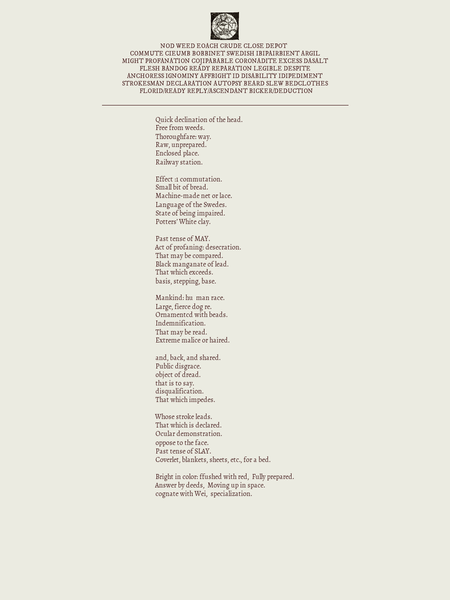

In [ ]:
title = " ".join([title for title, defn in p]).replace("\t", "")
poem = "\n".join([defn for title, defn in p])
im = draw_page(title, poem)
im.resize((450, 600), Image.ANTIALIAS)

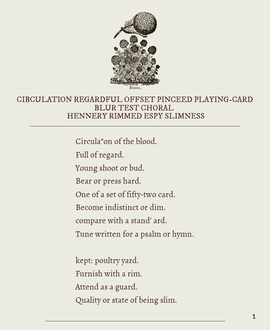

In [ ]:
p = ballade()
title = " ".join([title for title, defn in p]).replace("\t", "")
poem = "\n".join([defn for title, defn in p])
draw_page(title, poem, page_num=1, style="tweet").resize((270, 330), Image.ANTIALIAS)

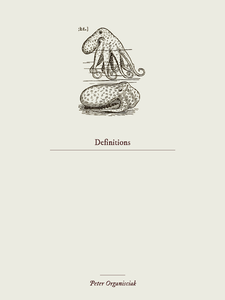

In [ ]:
def draw_cover(style="book"):
    
    hsize = 1200
    wsize = 900
    wmargin = 100
    hmargin = 100
    page_color = (235, 235, 225)
    ink_color = (70,30,30)
    illustration_height = 360
    title_fsize = 33
    
    if style == "tweet":
        hsize = 1100
        wsize = 900
        wmargin = 50
    toppos = hsize / 2

    im = Image.new('RGB', (wsize, hsize), color=page_color)
    draw = ImageDraw.Draw(im)
    
    draw.line((wmargin*2, toppos, im.size[0]-wmargin*2, toppos), fill=ink_color)
    
    title = "Definitions"
    titlefont = ImageFont.truetype("../fonts/IMFePIrm28P.ttf", title_fsize)
    titlew, titleh = draw.textsize(title, font=titlefont)
    draw.multiline_text(((im.size[0]-titlew)/2, toppos-titleh-20),title,
                        ink_color,font=titlefont, align="center")
    
    # Add squid image
    ill_full = Image.open("../data/illustration_images/826.png")
    ill = ill_full.resize((int(illustration_height*(ill_full.size[0] / ill_full.size[1])),
                          illustration_height),
                          Image.ANTIALIAS)
    illmask = create_img_mask(ill)

    im.paste(ill,
             (int((im.size[0]-(ill.size[0]))/2), int((toppos-titleh-ill.size[1])/2)),
             illmask)
    
    # Author Line
    author = "Peter Organisciak"
    authorfont = ImageFont.truetype("../fonts/IMFePIit28P.ttf", title_fsize-5)
    authorw, authorh = draw.textsize(author, font=authorfont)
    draw.multiline_text(((im.size[0]-authorw)/2, im.size[1]-hmargin+authorh/2),
                        author,
                        ink_color,font=authorfont, align="center")
    
    draw.line((wmargin*4, im.size[1]-hmargin, im.size[0]-wmargin*4, 
              im.size[1]-hmargin), fill=ink_color)

    return im

def draw_frontispiece(style="book"):
    
    hsize = 1200
    wsize = 900
    wmargin = 100
    hmargin = 100
    page_color = (235, 235, 225)
    ink_color = (70,30,30)
    illustration_height = 300
    title_fsize = 33
    
    if style == "tweet":
        hsize = 1100
        wsize = 900
        wmargin = 50
    toppos = hsize / 2

    im = Image.new('RGB', (wsize, hsize), color=page_color)
    draw = ImageDraw.Draw(im)
    
    # Add rose image
    ill_full = Image.open("../data/illustration_images/1060.png")
    ill = ill_full.resize((int(illustration_height*(ill_full.size[0] / ill_full.size[1])),
                          int(illustration_height)),
                          Image.ANTIALIAS)
    illmask = create_img_mask(ill)
    im.paste(ill,
             (int((im.size[0]-(ill.size[0]))/2), int((im.size[1]-(ill.size[1]))/2)),
             illmask)

    return im

def draw_blank(style="book"):
    hsize = 1200
    wsize = 900
    if style == "tweet":
        hsize = 1100
        wsize = 900
    page_color = (235, 235, 225)
    im = Image.new('RGB', (wsize, hsize), color=page_color)
    return im

draw_cover().resize((225, 300), Image.ANTIALIAS)

In [ ]:
draw_cover().save("../data/codexbooks/codex-0000-0-cover.png")
draw_frontispiece().save("../data/codexbooks/codex-0000-1-inside.png")
draw_blank().save("../data/codexbooks/codex-A-backblank.png")
draw_blank().save("../data/codexbooks/codex-B-backblank.png")

In [ ]:
for i in range(1, 101):
    poetry_types = [limerick, ballade, ballade, cinquian, alternate, abab_cdcd, couplets]
    ptype = random.choice(poetry_types)
    p = ptype()
    title = " ".join([title for title, defn in p]).replace("\t", "")
    poem = "\n".join([defn for title, defn in p])
    
    fname_num = str(i).rjust(4, "0")
    fname_title = title.replace("\t", "").replace("\n","").replace(" ", "_")
    im = draw_page(title, poem, page_num=i)
    im.save("../data/codexbooks/codex-{}.png".format(fname_num , fname_title))
    im = draw_page(title, poem, page_num=i, annotate=True)
    im.save("../data/codexannotate/codex-{}.png".format(fname_num , fname_title))

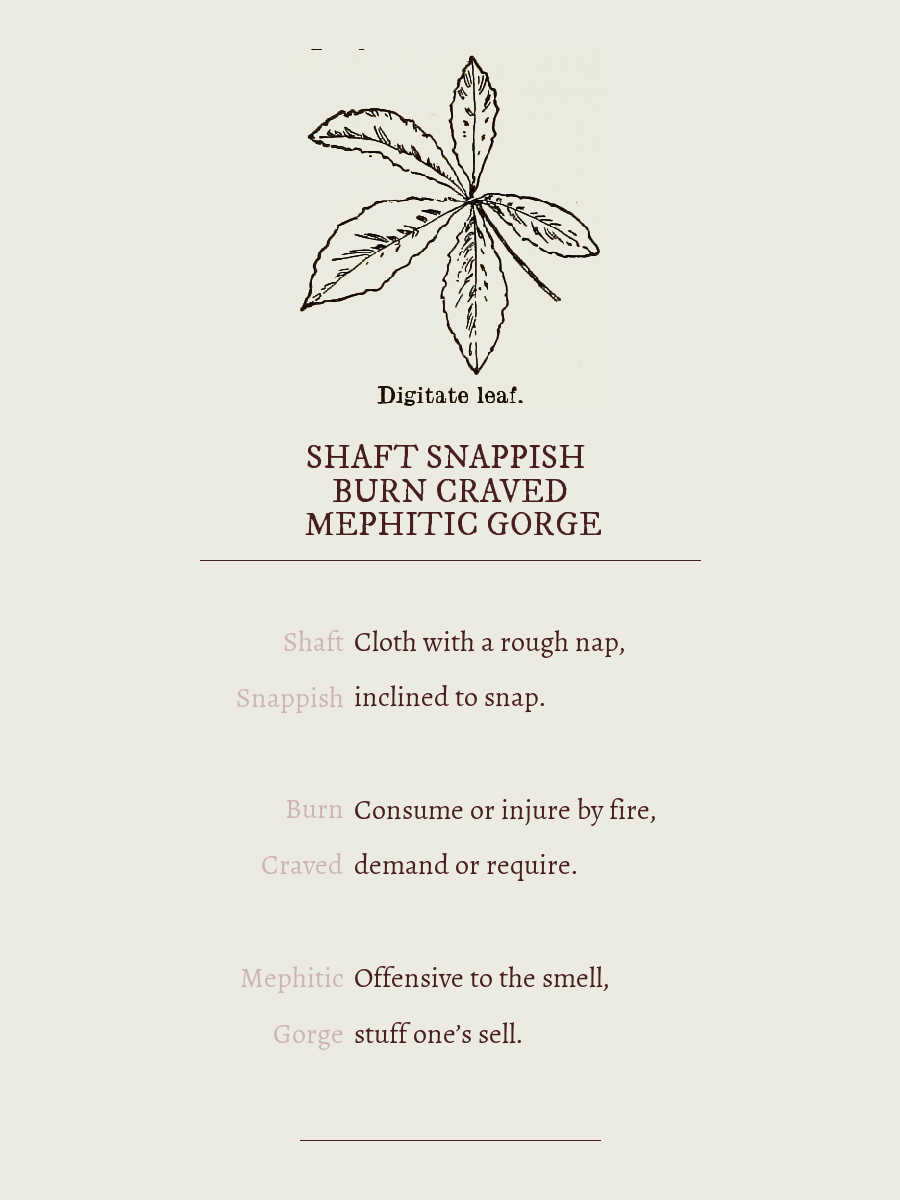

In [ ]:
ptype = random.choice(poetry_types)
p = ptype()
title = " ".join([title for title, defn in p]).replace("\t", "")
poem = "\n".join([defn for title, defn in p])
im = draw_page(title, poem, annotate=True)
im

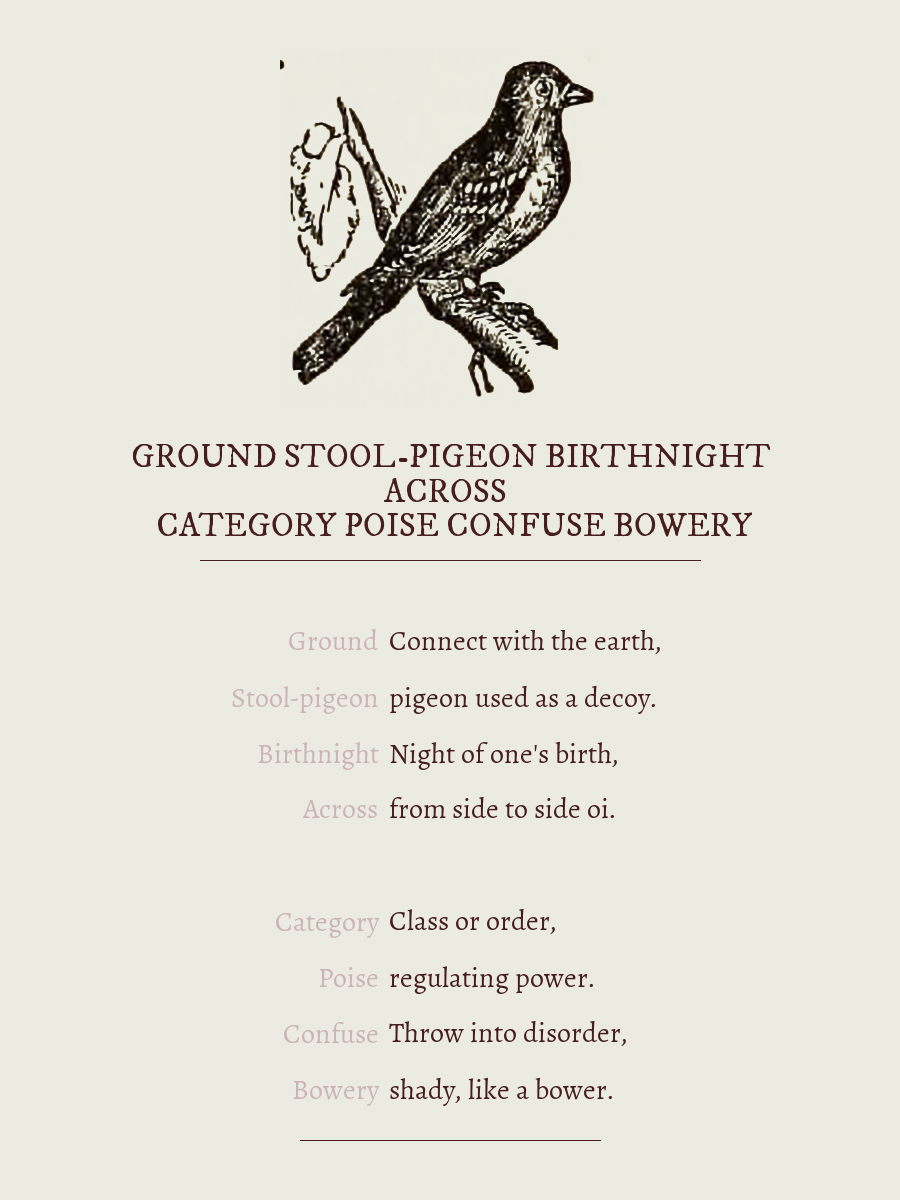

In [ ]:
i = 17
poetry_types = [limerick, ballade, ballade, cinquian, alternate, abab_cdcd, couplets]
ptype = random.choice(poetry_types)
p = ptype()
title = " ".join([title for title, defn in p]).replace("\t", "")
poem = "\n".join([defn for title, defn in p])

fname_num = str(i).rjust(4, "0")
fname_title = title.replace("\t", "").replace("\n","").replace(" ", "_")
im = draw_page(title, poem, annotate=True)
im.save("../data/codexbooks/codex-{}-{}.png".format(fname_num , fname_title))

im

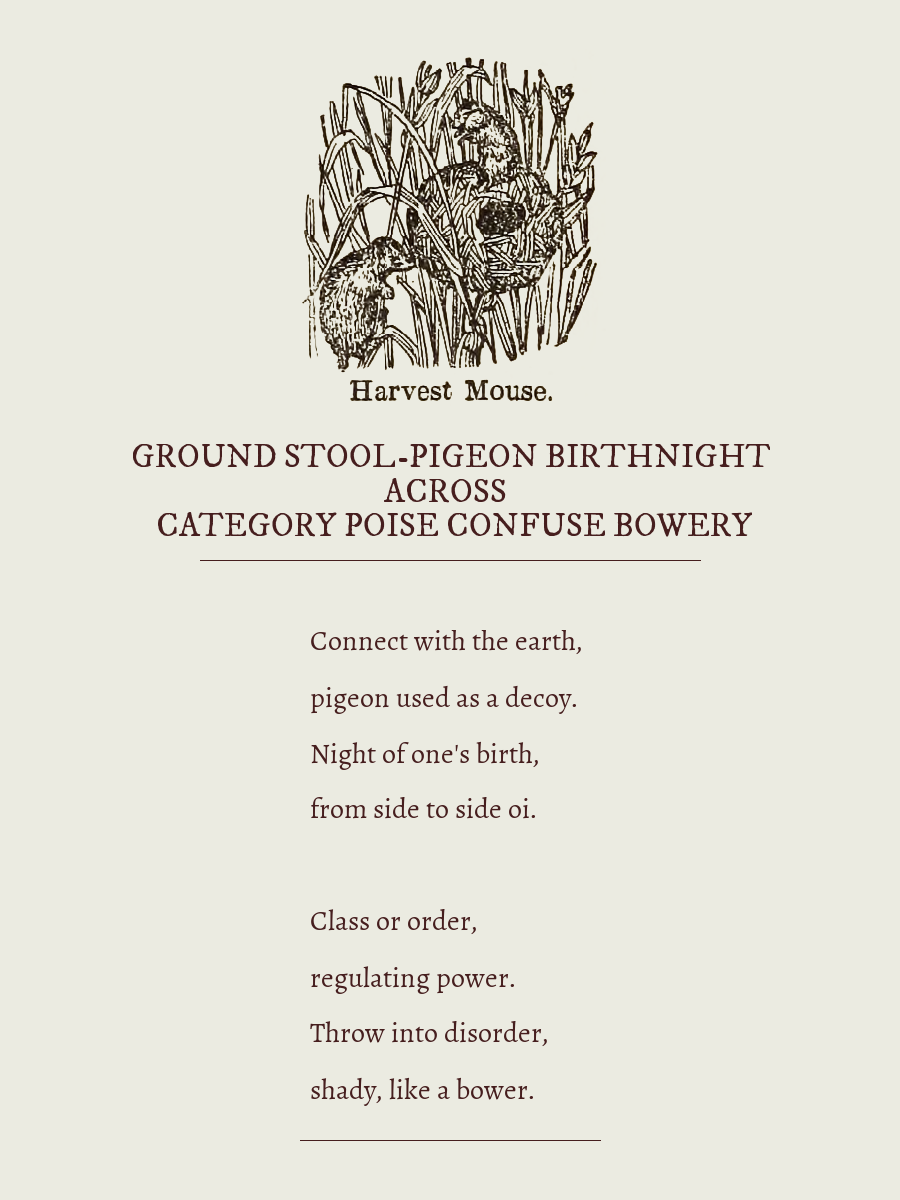

In [ ]:
draw_page(title, poem)

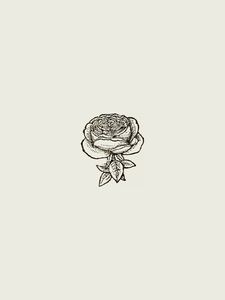

In [ ]:
draw_frontispiece().resize((225, 300), Image.ANTIALIAS)